In [1]:
%autosave 0

Autosave disabled


In [2]:
import warnings
warnings.filterwarnings('ignore')
# For ignoring warnings printed by R magic commands

In [3]:
import os
import glob

In [4]:
# Import pandas
import pandas as pd

In [5]:
# Load R magic
%load_ext rpy2.ipython
# Import ggplot2
%R require(ggplot2);

In [6]:
# If experiment parameters change, modify this function
def AddParametersAsColumns(df, folder):
    expParams = folder.split('.')
    cloudParams = expParams[1].split('_')
    optimizerParams = expParams[2].split('_')
    df['groupSizeDist'] = cloudParams[9]
    df['placementDist'] = cloudParams[10]
    df['colocateNumHostsPerLeaf'] = int(cloudParams[11])
    df['seed'] = int(cloudParams[14])
    df['algorithm'] = optimizerParams[1]
    df['numBitmaps'] = int(optimizerParams[2])
    df['numLeafsPerBitmap'] = int(optimizerParams[3])
    df['redundancyPerBitmap'] = int(optimizerParams[4])
    df['numRulesPerLeaf'] = int(optimizerParams[5])
    
# Turns all files of a given filname across a set of folders into a single dataframe
def DataSetAsDataFrame(filename, folders, headers, header=None):
    # Read dataset as dataframe
    def ReadDataSet(folder):
        df = pd.read_csv(folder + '/' + filename, sep=',', header=header, names=headers)
        AddParametersAsColumns(df, folder)
        return df
    # Get the list of dataframes
    dfs = map(ReadDataSet, folders)
    # Combine into a single dataframe
    df = pd.concat(dfs)
    return df

In [7]:
%%R 
plotTheme <- theme(legend.title=element_blank(), legend.position="top", legend.text=element_text(size=6))

In [8]:
os.chdir('/mnt/sdb1/baseerat/numerical-evals/11-23-2017/logs-100K-random')
folders = glob.glob("logs*_0.*")

In [9]:
ruleCountPerLeaf = DataSetAsDataFrame('rule_count_per_leaf.csv', 
                                      folders, ['leafId', 'numRules'])

In [10]:
groupCountPerTenant = DataSetAsDataFrame('group_count_per_tenant.csv', 
                                         folders, ['tenantId', 'groupCount'])

In [11]:
groupSizePerGroupPerTenant = DataSetAsDataFrame('group_size_per_group_per_tenant.csv', 
                                                folders, ['groupId', 'groupSize'])

In [12]:
groupsCoveredWithBitmapsOnly = DataSetAsDataFrame('groups_covered_with_bitmaps_only.csv', 
                                                  folders, 
                                                  ['index', 'groupsCovered', 'groupsCoveredWithoutDefaultBitmap'],
                                                  header=0)

In [13]:
trafficOverhead = DataSetAsDataFrame('traffic_overhead.csv', 
                                     folders, 
                                     ['index', 'trafficOverhead'])

In [14]:
leafSpineTraffic = DataSetAsDataFrame('leaf_spine_traffic_per_group_per_tenant.csv', 
                                      folders, 
                                      ['groupId', 'multicastTraffic', 'unicastTraffic', 'overlayTraffic',
                                       'baseeratTraffic'],
                                       header=0)

In [15]:
vmCountPerTenant = DataSetAsDataFrame('vm_count_per_tenant.csv', 
                                      folders, 
                                      ['tenantId', 'vmCount'])

In [16]:
ruleCountPerLeaf.head(2)

,leafId,numRules,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf
0,0,10000,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000
1,1,10000,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000


In [17]:
groupCountPerTenant.head(2)

,tenantId,groupCount,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf
0,0,34,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000
1,1,8,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000


In [18]:
groupSizePerGroupPerTenant.head(2)

,groupId,groupSize,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf
0,0,103,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000
1,1,107,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000


In [19]:
vmCountPerTenant.head(2)

,tenantId,vmCount,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf
0,0,184,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000
1,1,46,uniform,colocate-random-random,12,0,exact-match,10,1,0,10000


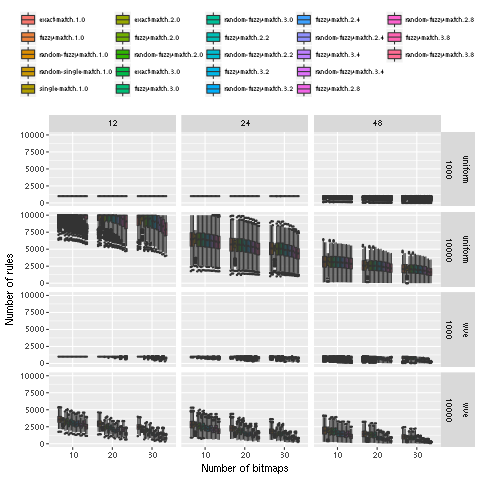

In [10]:
%%R -i ruleCountPerLeaf
ggplot(ruleCountPerLeaf) +
   geom_boxplot(aes(y=numRules, x=factor(numBitmaps), 
                    fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
                outlier.size=0.5) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   xlab("Number of bitmaps") +
   ylab("Number of rules") +
   plotTheme

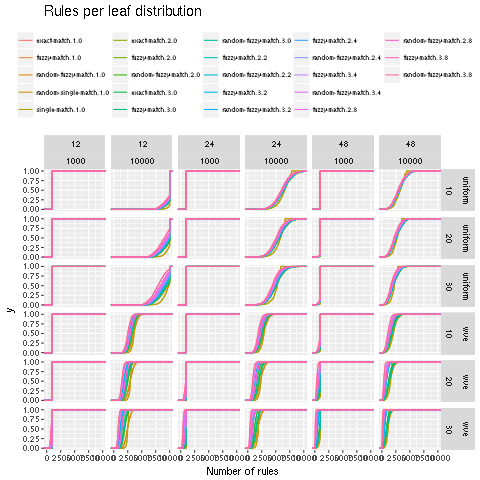

In [21]:
%%R -i ruleCountPerLeaf
ggplot(ruleCountPerLeaf) +
   stat_ecdf(aes(x=numRules, col=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap))) +
   facet_grid(groupSizeDist * numBitmaps ~ colocateNumHostsPerLeaf * numRulesPerLeaf) +
   ggtitle("Rules per leaf distribution") +
   xlab("Number of rules") +
   plotTheme

In [22]:
groupCountPerTenant[
    (groupCountPerTenant['algorithm'] == 'exact-match') &
    (groupCountPerTenant['groupSizeDist'] == 'wve') &
    (groupCountPerTenant['colocateNumHostsPerLeaf'] == 24) & 
    (groupCountPerTenant['numBitmaps'] == 10) & 
    (groupCountPerTenant['numLeafsPerBitmap'] == 1) &
    (groupCountPerTenant['numRulesPerLeaf'] == 1000)
]['groupCount'].quantile([0.0, 0.5, 0.99, 0.999, 0.9999, 1.0])

0.0000      1.0000
0.5000     17.0000
0.9900    516.2500
0.9990    909.0140
0.9999    926.1003
1.0000    927.0000
Name: groupCount, dtype: float64

In [23]:
groupSizePerGroupPerTenant[
    (groupSizePerGroupPerTenant['algorithm'] == 'exact-match') &
    (groupSizePerGroupPerTenant['colocateNumHostsPerLeaf'] == 24) & 
    (groupSizePerGroupPerTenant['numBitmaps'] == 10) & 
    (groupSizePerGroupPerTenant['numLeafsPerBitmap'] == 1) &
    (groupSizePerGroupPerTenant['numRulesPerLeaf'] == 1000)
].groupby('groupSizeDist')['groupSize'].quantile([0.0, 0.5, 0.99, 0.999, 0.9999, 1.0])

groupSizeDist        
uniform        0.0000       5.0000
               0.5000     143.0000
               0.9900    4259.0000
               0.9990    4837.5150
               0.9999    4976.1505
               1.0000    4997.0000
wve            0.0000       5.0000
               0.5000      12.0000
               0.9900     383.0000
               0.9990    4693.5150
               0.9999    4959.0000
               1.0000    4988.0000
Name: groupSize, dtype: float64

In [24]:
vmCountPerTenant[
    (vmCountPerTenant['algorithm'] == 'exact-match') & 
    (vmCountPerTenant['groupSizeDist'] == 'wve') & 
    (vmCountPerTenant['colocateNumHostsPerLeaf'] == 24) & 
    (vmCountPerTenant['numBitmaps'] == 10) & 
    (vmCountPerTenant['numLeafsPerBitmap'] == 1) &
    (vmCountPerTenant['numRulesPerLeaf'] == 1000)
]['vmCount'].quantile([0.0, 0.5, 0.99, 0.999, 0.9999, 1.0])

0.0000      10.0000
0.5000      97.0000
0.9900    2785.3300
0.9990    4902.0780
0.9999    4995.1013
1.0000    4999.0000
Name: vmCount, dtype: float64

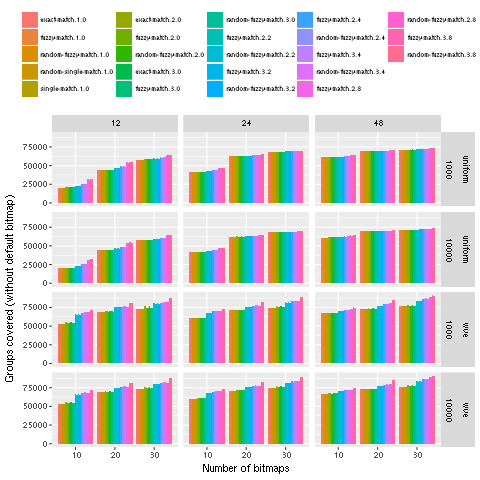

In [25]:
%%R -i groupsCoveredWithBitmapsOnly
ggplot(groupsCoveredWithBitmapsOnly) +
   geom_bar(aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
            stat="identity",position=position_dodge()) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   xlab("Number of bitmaps") +
   ylab("Groups covered (without default bitmap)") +
   plotTheme

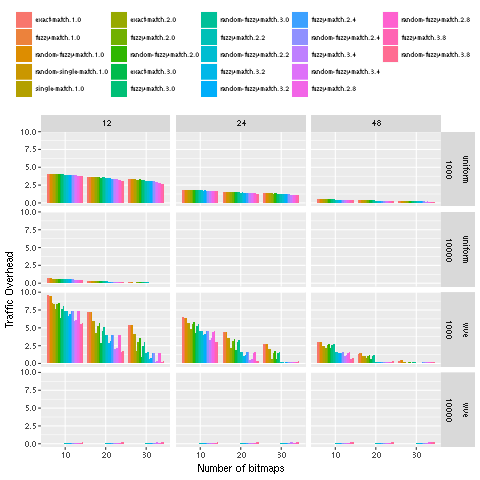

In [26]:
%%R -i trafficOverhead
ggplot(trafficOverhead) +
   geom_bar(aes(y=trafficOverhead, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
            stat="identity",position=position_dodge()) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme

In [27]:
overheads = leafSpineTraffic.groupby([
    'groupSizeDist', 'placementDist', 'colocateNumHostsPerLeaf', 'algorithm', 'numBitmaps', 'numLeafsPerBitmap', 
    'redundancyPerBitmap', 'numRulesPerLeaf', 'seed'])[
    ['unicastTraffic', 'multicastTraffic', 'baseeratTraffic', 'overlayTraffic']].agg('sum')
overheads.reset_index(inplace=True)

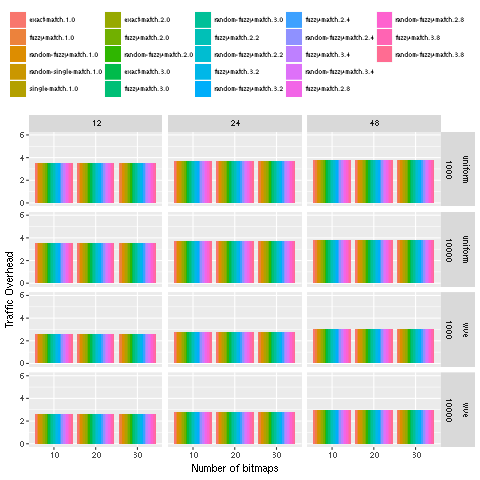

In [28]:
%%R -i overheads
ggplot(overheads) +
   geom_bar(aes(y=unicastTraffic/multicastTraffic, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
            stat="identity", position=position_dodge(),) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   ylim(c(0, 6)) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme

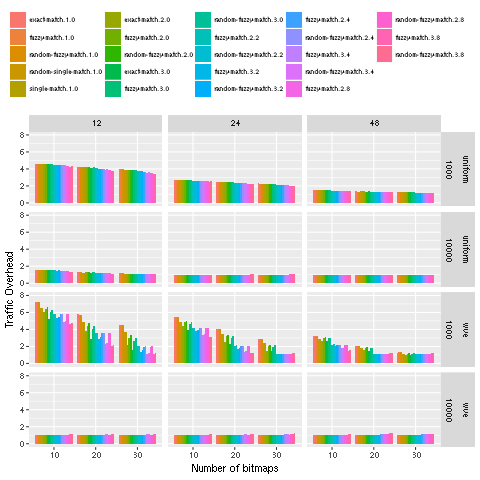

In [29]:
%%R -i overheads
ggplot(overheads) +
   geom_bar(aes(y=baseeratTraffic/multicastTraffic, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
            stat="identity", position=position_dodge(),) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   ylim(c(0, 8)) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme

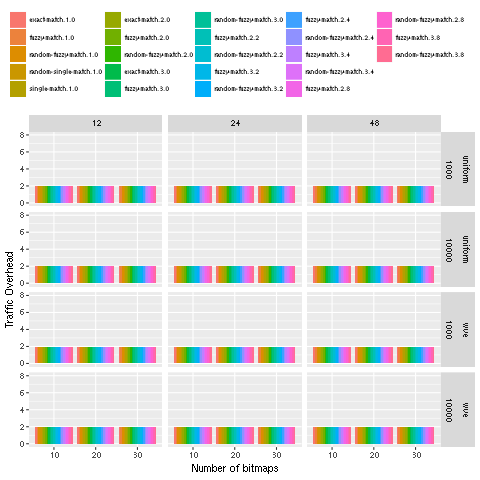

In [30]:
%%R -i overheads
ggplot(overheads) +
   geom_bar(aes(y=overlayTraffic/multicastTraffic, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
            stat="identity", position=position_dodge(),) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   ylim(c(0, 8)) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme